API: https://developer.sportradar.com/docs/read/golf/Golf_v3#golf-api-overview

High-level approach:
1. Define variables including which players we're predicting, which tournament is next, and how far back to use training data for.
2. Define helper functions
3. Ensure we have most recent season stats data and player info
4. Get all player historical tournaments data, historical season stats data, and relevant course info data. Write all to disk if necessary.
5. Combine data of all relevant stats from player and course with the total difference to par this person ended up shooting.
6. Clean up data, categorize some columns, scale others
7. Train model
8. Make prediction with current stats from players and info for next tournament



Important Notes:
- I chose to predict the players final scores relative to par, instead of their finishing position. This is because their finishing position is dependent upon
    how others perform in the tournament. I could have also predicted total strokes, but that is dependent upon what par is
- Right now I'm predicting how a player will perform in a tournament. We could instead predict how a player will perform in a given round. This would allow us to use
    tournament weather and conditions on a day-to-day basis better.
- The API only has data aggregated by season. This poses two problems with training/prediction:
    1. During training, the model will be using data after the tournament it's training on. For example, when training on the Masters tournament (which occurs in May),
        it should ideally only be using player data up to May, but will actually be using data from the entire season including after May.
    2. When predicting, we will be using the player data from the current season. For tournaments that are early in the season, this will be minimal data.
        It may be better to use previous season player data for first few tournaments until we have enough data.
- The https://datagolf.com/raw-data-archive API has much more granular strokes gained data. This is paid subscription and requires scratch plus ($30/month)



Data:
- Tournament Schedule -- {URL}/tournaments/schedule -- https://developer.sportradar.com/docs/read/golf/Golf_v3#tournament-schedule:
        High level tournament data for specific season. Includes course details. Sample data in "temp/tournaments_schedule_2023.csv"

- Tournament Leaderboard -- {URL}/tournaments/{TOURNAMENT_ID}/leaderboard -- https://developer.sportradar.com/docs/read/golf/Golf_v3#tournament-leaderboard:
        Full leaderboard data of specific tournament. Sample data in "temp/zozo_leaderboard_2023.csv"
    
- Tournament Summary -- {URL}/tournaments/{TOURNAMENT_ID}/summary -- https://developer.sportradar.com/docs/read/golf/Golf_v3#tournament-summary:
        High level tournament info. "venue" has par and course length. "rounds" has weather and conditions of each round.
    
- Player Statistics -- {URL}/players/statistics -- https://developer.sportradar.com/docs/read/golf/Golf_v3#player-statistics:
        Season statistics for all golfers. Sample data in "temp/player_stats_2023.csv". IMPORTANT: this only is accurate for v2 of API, NOT v3
    
- Player Profile -- {URL}/players/{player_id}/profile -- https://developer.sportradar.com/docs/read/golf/Golf_v3#player-profile:
        Contains "previous_tournaments" and "statistics" of specific player for all previous seasons. Sample data in "temp/jt_player_previous_tournaments.csv" and 
        "temp/jt_player_statistics.csv"

- Course Difficulty -- Downloaded manually - https://datagolf.com/course-table?sort_cat=sg_difficulty&sort=app_sg&diff=hardest:
        Had to manually change a lot of course names to match what's available in the sportradar API


## Imports + Globals

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import time
import json
import os
import ast
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
API_KEY = os.environ['pga_api_key']

In [3]:
PROJECT_PATH = '/Users/huntermitchell/Documents/Documents/PYTHON_FILES/PGA_Winner_Prediction/v2'

CURRENT_YEAR = datetime.today().year
YEARS_BACK = 5

SEED = 2015

ALL_PLAYER_STATS_URL = "https://api.sportradar.us/golf/trial/pga/v2/en/{year}/players/statistics.json?api_key={api_key}"

PLAYER_STATS_URL = "https://api.sportradar.us/golf/trial/v3/en/players/{player_id}/profile.json?api_key={api_key}"

TOURNAMENTS_SCHEDULE_URL = "https://api.sportradar.us/golf/trial/pga/v3/en/{year}/tournaments/schedule.json?api_key={api_key}"

TOURNAMENT_SUMMARY_URL = "https://api.sportradar.us/golf/trial/v3/en/{year}/tournaments/{tournament_id}/summary.json?api_key={api_key}"

TOURNAMENT_LEADERBOARD_URL = "https://api.sportradar.us/golf/trial/pga/v3/en/{year}/tournaments/{tournament_id}/leaderboard.json?api_key={api_key}"

NEW_REQUEST_CURRENT_SEASON_STATS = False
NEW_REQUEST_TOURNAMENT_SCHEDULE = False
NEW_REQUEST_PREVIOUS_TOURNAMENTS = False

FEATURES = ['course_difficulty', 'drive_avg', 'drive_acc', 'gir_pct', 'putt_avg','strokes_gained', 'scrambling_pct', 'scoring_avg',
    'strokes_gained_tee_green', 'strokes_gained_total', 'yardage/par', 'avg_temp', 'avg_wind_speed', 'cloudy', 'sunny', 'rainy']
LABELS = ['score']
TEST_SIZE = 0.1

FEATURES_TO_NOT_SCALE = ['cloudy','sunny','rainy']
FEATURES_TO_SCALE = [col for col in FEATURES if col not in FEATURES_TO_NOT_SCALE]

STATISTICS_FEATURES = ['drive_avg','drive_acc','gir_pct','putt_avg','strokes_gained','scrambling_pct','scoring_avg','strokes_gained_tee_green','strokes_gained_total']

In [4]:
PLAYER_NAMES = ['xander_schauffele','collin_morikawa','keegan_bradley','sungjae_im','rickie_fowler','hideki_matsuyama','sahith_theegala','cameron_davis','eric_cole']

NEXT_TOURNAMENT_CONDITION_INFO = {'avg_temp': 74, 'avg_wind_speed': 9, 'cloudy': 0, 'sunny': 1, 'rainy': 0}

## Functions

In [72]:
def get_player_info(player_name, current_season_stats_df):
    player_info = {}
    first_name = player_name.split('_')[0].title()
    last_name = player_name.split('_')[1].title()
    id = current_season_stats_df[(current_season_stats_df['first_name'] == first_name) & (current_season_stats_df['last_name'] == last_name)]['id'].values[0]
    player_info['first_name'] = first_name
    player_info['last_name'] = last_name
    player_info['id'] = id
    return player_info

def get_tournaments_schedule(url, year, new_request=False):
    print(f'Getting {year} tournaments schedule...')
    file_path = f'{PROJECT_PATH}/tournaments_schedule/{year}_tournaments.csv'
    if new_request:
        response = requests.get(url)
        df = pd.DataFrame(response.json()['tournaments'])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)
    return df

def get_next_tournament(tournaments_schedule_df):
    return tournaments_schedule_df[tournaments_schedule_df['status']=='scheduled'].iloc[0]

def get_player_previous_tournaments_info(url, player_name, new_request=False):
    file_path = f'{PROJECT_PATH}/players_previous_tournaments/{player_name}.csv'
    if new_request:
        response = requests.get(url)
        df = pd.DataFrame(response.json()['previous_tournaments'])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)
    return df

def get_current_season_stats_df(year, new_request=False):
    print(f'Getting this year season stats for player info lookup...')
    file_path = f'{PROJECT_PATH}/all_player_season_stats/{year}_season_stats.csv'
    if new_request:
        response = requests.get(ALL_PLAYER_STATS_URL.format(year=year, api_key=API_KEY))
        df = pd.DataFrame(response.json()['players'])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)
    return df

def backfill_all_player_season_stats(years_back = YEARS_BACK):
    print("Backfilling all player season stats...")
    for year in range(CURRENT_YEAR - years_back, CURRENT_YEAR + 1):
        file_path = f'{PROJECT_PATH}/all_player_season_stats/{year}_season_stats.csv'
        if not os.path.isfile(file_path):
            time.sleep(3)
            response = requests.get(ALL_PLAYER_STATS_URL.format(year=year, api_key=API_KEY))
            df = pd.DataFrame(response.json()['players'])
            df.to_csv(file_path, index=False)

def backfill_tournament_summaries(tournament_ids):
    print("Backfilling tournament summaries of all previous tournaments for players we're predicting...")
    for tournament_id in tournament_ids:
        file_path = f'{PROJECT_PATH}/tournament_summaries/{tournament_id}.json'
        if not os.path.isfile(file_path):
            time.sleep(1)
            url = TOURNAMENT_SUMMARY_URL.format(year=CURRENT_YEAR,tournament_id=tournament_id,api_key=API_KEY)
            response = requests.get(url)
            with open(file_path, 'w') as fp:
                json.dump(response.json(), fp)

def generate_previous_tournaments_training_df(player_previous_tournaments_df):
    """
    Stroke play only, no playoffs, only PGA Tour, no TOUR Championship. Then filter to only last YEARS_BACK years
    """
    training_df = player_previous_tournaments_df[
        (player_previous_tournaments_df['event_type']=='stroke') & \
        (~player_previous_tournaments_df['name'].str.endswith('Playoff')) & \
        (player_previous_tournaments_df['name'] != "TOUR Championship")
        ][['id','name','first_name','last_name','seasons','leaderboard','start_date']]\
        .rename(columns={'id':'tournament_id','name':'tournament_name'})

    training_df['full_name'] = training_df['first_name'] + '_' + training_df['last_name']
    training_df['seasons'] = training_df['seasons'].apply(ast.literal_eval)
    training_df['leaderboard'] = training_df['leaderboard'].apply(ast.literal_eval)

    training_df = training_df.explode('seasons')

    training_df = training_df[training_df['seasons'].apply(lambda x: x['tour']['name']) == 'PGA Tour']

    training_df['season_id'] = training_df['seasons'].apply(lambda x: x['id'])
    training_df['score'] = training_df['leaderboard'].apply(lambda x: x['score'])
    training_df['start_date'] = pd.to_datetime(training_df['start_date'], format='%Y-%m-%d')

    training_df = training_df[training_df['start_date'] >= datetime(year=CURRENT_YEAR - YEARS_BACK,month=5,day=1)]
    training_df = training_df.drop(columns=['seasons','leaderboard','first_name','last_name']).reset_index(drop=True)

    return training_df

def get_course_difficulty_df():
    course_difficulty_df = pd.read_csv(f'{PROJECT_PATH}/course_difficulty_stats/dg_course_table.csv')[['course','adj_score_to_par']]
    return course_difficulty_df.rename(columns={'adj_score_to_par':'course_difficulty'})

def generate_season_stats_df(first_names, last_names):
    """
    Combine all season stats from "all_player_season_stats" folder
    """
    season_stats_df_list = []

    for year in range(CURRENT_YEAR-YEARS_BACK, CURRENT_YEAR+1):
        temp_df = pd.read_csv(f'{PROJECT_PATH}/all_player_season_stats/{year}_season_stats.csv')
        temp_df['year'] = year
        season_stats_df_list.append(temp_df)

    season_stats_df = pd.concat(season_stats_df_list)

    season_stats_df = season_stats_df[(season_stats_df['first_name'].isin(first_names)) & (season_stats_df['last_name'].isin(last_names))]
    season_stats_df['statistics'] = season_stats_df['statistics'].apply(ast.literal_eval)

    return season_stats_df

def generate_season_stats_training_df(season_stats_df, statistics_features):
    """
    Extract wanted features from "statistics" object column
    """
    for feature in statistics_features:
        season_stats_df[feature] = season_stats_df['statistics'].apply(lambda x: x[feature])
    
    season_stats_df['full_name'] = season_stats_df['first_name'] + '_' + season_stats_df['last_name']
    return season_stats_df.drop(columns=['id','country','statistics','first_name','last_name']).reset_index(drop=True)

def get_tournament_summary_training_df(tournament_ids):
    """
    Combine relevant course stats from "tournament_summaries" folder
    """
    tournament_summaries_data = []

    for tournament_id in tournament_ids:
        with open(f'{PROJECT_PATH}/tournament_summaries/{tournament_id}.json') as json_file:
            json_data = json.load(json_file)
            venue_data = json_data['venue']
            rounds_data = json_data['rounds']
            tournament_data = [tournament_id,
                            venue_data['name'],
                            venue_data['courses'][0]['yardage'],
                            venue_data['courses'][0]['par'],
                            [round_data['weather']['temp'] for round_data in rounds_data if 'weather' in round_data],
                            [round_data['weather']['condition'] for round_data in rounds_data if 'weather' in round_data],
                            [round_data['weather']['wind']['speed'] for round_data in rounds_data if 'weather' in round_data]
                            ]
            tournament_summaries_data.append(tournament_data)

    return pd.DataFrame(data=tournament_summaries_data, columns=['tournament_id','course','yardage','par','temps','conditions','wind_speeds'])

def combine_training_data(previous_tournaments_training_df, season_stats_training_df, tournament_summary_training_df, course_difficulty_df):
    training_df = previous_tournaments_training_df.merge(tournament_summary_training_df, how='left', on='tournament_id')
    training_df['year'] = training_df['start_date'].apply(lambda x: x.year if x.month >=3 else x.year-1) # if tourney is before March, we use last season stats
    training_df = training_df.merge(season_stats_training_df, how='left', on=['full_name','year'])
    return training_df.merge(course_difficulty_df, how='left',on='course')

def condition_mapping(condition):
    if 'rain' in condition or 'shower' in condition: return 'rainy'
    elif 'cloudy' in condition or condition == 'overcast': return 'cloudy'
    elif condition in ['clear','sunny']: return 'sunny'

def categorize_course_difficulty(difficulty):
    if difficulty >= 0.5:
        return 'hard'
    elif difficulty <= -0.5:
        return 'easy'
    else: return 'average'

def categorize_wind(wind):
    if wind >= 11.0:
        return 'windy'
    elif wind <= 7.0:
        return 'calm'
    else: return 'average'

def categorize_temp(temp):
    if temp >= 81.0:
        return 'hot'
    elif temp <= 68.0:
        return 'cold'
    else: return 'average'

def add_past_performance_features(df, features):
    for feature in features:
        df = df.sort_values(by=['full_name', feature, 'start_date'])
        df[f'past_performance_{feature}'] = df.groupby(['full_name', feature])['score'].expanding().mean().reset_index(drop=True)
    return df

def condition_one_hot_encode(conditions, condition_category):
    if len([condition for condition in conditions if condition == condition_category]) >= 2:
        return 1
    else:
        return 0

def engineer_features(training_df):
    # we get rid of rows with less than 3 days value of course conditions
    training_df = training_df[(training_df['temps'].str.len() >= 3) & (training_df['conditions'].str.len() >= 3) & (training_df['wind_speeds'].str.len() >= 3)]
    # we don't have season stats data for some players from 5+ years ago, so drop rows with nulls in those columns
    training_df = training_df.dropna(subset=STATISTICS_FEATURES)

    training_df['yardage/par'] = training_df['yardage']/training_df['par']
    training_df['avg_temp'] = training_df['temps'].apply(lambda x: round(sum(x) / len(x)))
    training_df['avg_wind_speed'] = training_df['wind_speeds'].apply(lambda x: round(sum(x) / len(x)))

    training_df['conditions_mapped'] = training_df['conditions'].apply(lambda conditions: [condition_mapping(condition.lower()) for condition in conditions])

    # fill course_difficulty null values with column mean
    training_df['course_difficulty'] = training_df['course_difficulty'].fillna(0.0)

    # we do 3 one-hot categories: Cloudy, Sunny, and Rain.
    condition_categories = ['cloudy', 'sunny','rainy']

    for condition_category in condition_categories:
        training_df[condition_category] = training_df['conditions_mapped'].apply(lambda conditions: condition_one_hot_encode(conditions, condition_category))

    return training_df.drop(columns=['yardage','par','temps','conditions','wind_speeds','conditions_mapped'])

def plot(x_label, y_label, df):
    plt.figure(figsize=(5,5))

    x = df[x_label].values
    y = df[y_label].values
    plt.scatter(x, y)

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x+b)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

def get_score(model, x_train_scaled, y_train):
  cv_score = cross_val_score(model, x_train_scaled, y_train, scoring = "neg_mean_squared_error", cv = 8)
  rmse = np.sqrt(-cv_score)
  print('Cross-Validation Root Mean Squared Error:', rmse)
  print('Average Root Mean Squared Error:', round(np.mean(rmse), 5))
  print('Standard deviation:', round(rmse.std(), 5))

def get_results(preds, y_test):
  score = np.sqrt(mean_squared_error(preds,y_test.values))
  print(f"Final RMSE: {round(score,5)}")

def get_next_tournament_course_difficulty(course_difficulty_df, course):
    try:
        return course_difficulty_df[course_difficulty_df['course']==course]['course_difficulty'].values[0]
    except IndexError:
        print('Course difficulty not available. Setting to 0.0')
        return 0.0

def generate_pred_df(season_stats_df, next_tournament_course_info, next_tournament_course_difficulty, next_tournament_condition_info):
    df = season_stats_df[season_stats_df['year']==CURRENT_YEAR]
    df['course_difficulty'] = next_tournament_course_difficulty
    df['yardage/par'] = next_tournament_course_info['yardage']/next_tournament_course_info['yardage']
    for i in next_tournament_condition_info.items():
        df[i[0]] = i[1]
    
    return df.reset_index(drop=True)

## Setup

In [6]:
current_season_stats_df = get_current_season_stats_df(CURRENT_YEAR, new_request=NEW_REQUEST_CURRENT_SEASON_STATS)

Getting this year season stats for player info lookup...


In [7]:
players = {player: get_player_info(player, current_season_stats_df) for player in PLAYER_NAMES}
player_first_names = [info['first_name'] for _,info in players.items()]
player_last_names = [info['last_name'] for _,info in players.items()]

In [8]:
print(players)

{'xander_schauffele': {'first_name': 'Xander', 'last_name': 'Schauffele', 'id': '26dc0bda-b9a8-4303-9c1c-ddecda3817d2'}, 'collin_morikawa': {'first_name': 'Collin', 'last_name': 'Morikawa', 'id': 'f0ff1391-fc29-41bf-b46a-cd5ef9f63ad9'}, 'keegan_bradley': {'first_name': 'Keegan', 'last_name': 'Bradley', 'id': '0b5d3fd6-e3ec-4efd-8743-60db44c87425'}, 'sungjae_im': {'first_name': 'Sungjae', 'last_name': 'Im', 'id': 'ac1db384-8cb4-4223-bc46-60f4ed963645'}, 'rickie_fowler': {'first_name': 'Rickie', 'last_name': 'Fowler', 'id': '5735703a-32d9-4a6c-8b24-6596f300bc44'}, 'hideki_matsuyama': {'first_name': 'Hideki', 'last_name': 'Matsuyama', 'id': 'd45bcf4a-5803-4b0b-ab6c-6427a76cecf7'}, 'sahith_theegala': {'first_name': 'Sahith', 'last_name': 'Theegala', 'id': '25faf9c2-3b45-4630-aac8-d11229cde0a1'}, 'cameron_davis': {'first_name': 'Cameron', 'last_name': 'Davis', 'id': 'f2bc6b83-fab1-4567-8bcf-9287d1940f2d'}, 'eric_cole': {'first_name': 'Eric', 'last_name': 'Cole', 'id': 'c01c741a-fd91-4e1c-8d

In [9]:
tournaments_schedule_df = get_tournaments_schedule(url=TOURNAMENTS_SCHEDULE_URL.format(year=CURRENT_YEAR,api_key=API_KEY),
                                                   year=CURRENT_YEAR, new_request=NEW_REQUEST_TOURNAMENT_SCHEDULE)

Getting 2023 tournaments schedule...


In [10]:
next_tournament = get_next_tournament(tournaments_schedule_df)
print(next_tournament)

id                                231bafc7-b92c-49f8-ab5a-f3c705ae33b8
name                                                 ZOZO CHAMPIONSHIP
event_type                                                      stroke
purse                                                        8500000.0
winning_share                                                      NaN
currency                                                           USD
points                                                             NaN
start_date                                                  2023-10-19
end_date                                                    2023-10-22
course_timezone                                             Asia/Tokyo
network                                                            NaN
total_rounds                                                       NaN
status                                                       scheduled
cutline                                                            NaN
projec

## Generate Training Data

In [11]:
player_previous_tournaments_dfs = []

for player in players.keys():
    if NEW_REQUEST_PREVIOUS_TOURNAMENTS: time.sleep(1)
    temp_df = get_player_previous_tournaments_info(PLAYER_STATS_URL.format(player_id=players[player]['id'],api_key=API_KEY),
                                                                            player,
                                                                            new_request=NEW_REQUEST_PREVIOUS_TOURNAMENTS)
    temp_df['first_name'] = players[player]['first_name']
    temp_df['last_name'] = players[player]['last_name']
    player_previous_tournaments_dfs.append(temp_df)

player_previous_tournaments_df = pd.concat(player_previous_tournaments_dfs)

In [12]:
player_previous_tournaments_df.head()

,id,name,event_type,currency,course_timezone,coverage,status,scoring_system,seasons,leaderboard,...,points,start_date,end_date,network,winning_share,cut_round,cutline,projected_cutline,first_name,last_name
0,24a5a75b-c60e-4029-befb-caaec2f52d31,World Golf Championships-HSBC Champions Playoff,stroke,USD,Asia/Shanghai,full,closed,stroke,[{'id': '8cf42dd8-8a1e-4a8a-9137-dc6ac59cd63d'...,"{'position': 1, 'tied': False, 'score': -1, 's...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Xander,Schauffele
1,7c169ad4-434a-4231-88c8-778ecdf52283,Sentry Tournament of Champions Playoff,stroke,USD,Pacific/Honolulu,full,closed,stroke,[{'id': '83eb0a3a-dd69-40d3-a9ba-f49e398fdb61'...,"{'position': 3, 'tied': False, 'score': 0, 'st...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Xander,Schauffele
2,e1a1f28c-f025-489c-ad7a-f67f20ebc72a,World Golf Championships-HSBC Champions Playoff,stroke,USD,Asia/Shanghai,full,closed,stroke,[{'id': '83eb0a3a-dd69-40d3-a9ba-f49e398fdb61'...,"{'position': 2, 'tied': False, 'score': 0, 'st...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Xander,Schauffele
3,27816bd4-51c7-4697-843a-ea7622db2487,Career Builder Challenge,stroke,USD,America/Los_Angeles,full,closed,stroke,[{'id': 'f7df115a-0ddd-4894-8e81-07e27f533067'...,"{'position': 92, 'tied': True, 'score': -6, 's...",...,500.0,2016-01-21,2016-01-24,The Golf Channel,1044000.0,NaN,NaN,NaN,Xander,Schauffele
4,74c1dfd9-635a-4b59-88fc-f40e48e4532b,Farmers Insurance Open,stroke,USD,America/Los_Angeles,full,closed,stroke,[{'id': 'f7df115a-0ddd-4894-8e81-07e27f533067'...,"{'position': 143, 'tied': True, 'score': 7, 's...",...,500.0,2016-01-28,2016-01-31,"The Golf Channel, CBS",1170000.0,NaN,NaN,NaN,Xander,Schauffele


In [13]:
backfill_all_player_season_stats(YEARS_BACK)

Backfilling all player season stats...


In [14]:
previous_tournaments_training_df = generate_previous_tournaments_training_df(player_previous_tournaments_df)

In [15]:
previous_tournaments_training_df

,tournament_id,tournament_name,start_date,full_name,season_id,score
0,f1458ef8-6d57-4b9d-b35b-ae163c35bf63,Wells Fargo Championship,2018-05-03,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,7
1,6ff392df-0da8-45df-9733-f8460fd6dc8f,THE PLAYERS Championship,2018-05-10,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,-14
2,b3b52f97-3c5f-49f8-94ac-e2f03f5879f4,Fort Worth Invitational,2018-05-24,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,4
3,579d7c64-2904-4ce6-b9b2-8998794278d1,the Memorial Tournament presented by Nationwide,2018-05-31,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,2
4,ebdd3311-2abf-434d-9b7e-00396078c279,U.S. Open,2018-06-14,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,6
...,...,...,...,...,...,...
933,97540454-f4b7-41a6-9a0d-d3c5bcc09442,FedEx St. Jude Championship,2023-08-10,Eric_Cole,ece9907c-6fe3-4944-8cb9-bb1033270259,-6
934,62335a36-7fd7-41d7-a729-30ded11fcd9c,BMW Championship,2023-08-17,Eric_Cole,ece9907c-6fe3-4944-8cb9-bb1033270259,-3
935,8700aba2-5e41-44cf-9178-91a8a990fd4e,Fortinet Championship,2023-09-14,Eric_Cole,ece9907c-6fe3-4944-8cb9-bb1033270259,-16
936,11630794-9c9a-4b3d-b15f-ce85bad28315,Sanderson Farms Championship,2023-10-05,Eric_Cole,ece9907c-6fe3-4944-8cb9-bb1033270259,-9


In [16]:
backfill_tournament_summaries(previous_tournaments_training_df['tournament_id'].unique())

Backfilling tournament summaries of all previous tournaments for players we're predicting...


In [17]:
season_stats_df = generate_season_stats_df(player_first_names, player_last_names)
print("Available features from season stats data: ",season_stats_df['statistics'].values[0])

Available features from season stats data:  {'events_played': 27, 'first_place': 0, 'second_place': 2, 'third_place': 2, 'top_10': 7, 'top_25': 12, 'cuts': 5, 'cuts_made': 22, 'withdrawals': 0, 'points': 581.0, 'points_rank': 15, 'earnings': 4047538.0, 'earnings_rank': 18, 'drive_avg': 304.6, 'drive_acc': 59.09, 'gir_pct': 65.79, 'putt_avg': 1.764, 'sand_saves_pct': 48.91, 'birdies_per_round': 3.81, 'holes_per_eagle': 239.1, 'world_rank': 18, 'strokes_gained': 0.125, 'hole_proximity_avg': '37\' 2"', 'scrambling_pct': 58.76, 'scoring_avg': 70.486, 'strokes_gained_tee_green': 0.386, 'strokes_gained_total': 0.511, 'total_driving': 155}


In [18]:
season_stats_training_df = generate_season_stats_training_df(season_stats_df, STATISTICS_FEATURES)

In [19]:
season_stats_training_df.head()

,year,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,full_name
0,2018,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,Xander_Schauffele
1,2018,302.0,61.69,69.77,1.747,0.115,61.08,70.022,1.028,1.143,Hideki_Matsuyama
2,2018,299.5,67.90,69.41,1.781,-0.355,58.08,70.303,1.231,0.876,Keegan_Bradley
3,2018,300.6,64.47,69.84,1.740,0.303,64.21,69.435,0.947,1.249,Rickie_Fowler
4,2019,295.9,65.45,67.61,1.736,0.323,64.53,70.252,0.700,1.023,Sungjae_Im


In [20]:
tournament_summary_training_df = get_tournament_summary_training_df(previous_tournaments_training_df['tournament_id'].unique())

In [21]:
tournament_summary_training_df.head()

,tournament_id,course,yardage,par,temps,conditions,wind_speeds
0,f1458ef8-6d57-4b9d-b35b-ae163c35bf63,Quail Hollow Club,7554,71,"[81, 82, 78, 80]","[Partly cloudy, Partly cloudy, Overcast, Partl...","[9, 11, 12, 12]"
1,6ff392df-0da8-45df-9733-f8460fd6dc8f,TPC Sawgrass,7189,72,"[79, 82, 83, 79]","[Partly cloudy, Partly cloudy, Sunny, Sunny]","[13, 7, 12, 8]"
2,b3b52f97-3c5f-49f8-94ac-e2f03f5879f4,Colonial CC,7209,70,"[88, 81, 95, 97]","[Partly cloudy, Partly cloudy, Sunny, Partly c...","[6, 11, 4, 7]"
3,579d7c64-2904-4ce6-b9b2-8998794278d1,Muirfield Village GC,7392,72,"[87, 76, 78, 81]","[Sunny, Sunny, Partly cloudy, Partly cloudy]","[12, 4, 6, 16]"
4,ebdd3311-2abf-434d-9b7e-00396078c279,Shinnecock Hills Golf Club,7440,70,"[59, 59, 57, 57]","[Clear, Clear, Light Drizzle And Rain, Light D...","[0, 0, 8, 8]"


In [22]:
course_difficulty_df = get_course_difficulty_df()

In [23]:
course_difficulty_df.head()

,course,course_difficulty
0,St. Andrews,-0.29
1,Kiawah Island Resort,2.57
2,Trump National Doral,1.89
3,PGA National Resort and Spa,1.42
4,Eagle Point Golf Club,0.70


In [24]:
course_difficulty_courses = sorted(course_difficulty_df.course.unique())
#print("Courses with difficulty stats:\n",course_difficulty_courses)
training_data_courses = sorted(tournament_summary_training_df.course.unique())
#print("\n\nCourses in training data:\n",training_data_courses)

print('Courses in training data but not in course difficulty data:\n',sorted(set(training_data_courses)-set(course_difficulty_courses)))

Courses in training data but not in course difficulty data:
 ['Accordia Golf Narashino Country Club', 'Albany, The Bahamas', 'Carnoustie Golf Links', 'Coco Beach Golf and Country Club', 'El Camaleon GC at the Mayakoba Resort', 'Montreux Golf and Country Club', 'Nine Bridges Golf Club', 'Port Royal Golf Course', 'Puntacana Resort & Club', 'Royal Portrush Golf Club', "Royal St. George's Golf Club", 'Sheshan International GC', 'Shinnecock Hills Golf Club', 'Silverado Resort and Spa (North Course)', 'TPC Kuala Lumpur ', 'Tahoe Mountain Club', 'The Country Club of Brookline', 'The Greenbrier']


In [25]:
previous_tournaments_training_df.head()

,tournament_id,tournament_name,start_date,full_name,season_id,score
0,f1458ef8-6d57-4b9d-b35b-ae163c35bf63,Wells Fargo Championship,2018-05-03,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,7
1,6ff392df-0da8-45df-9733-f8460fd6dc8f,THE PLAYERS Championship,2018-05-10,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,-14
2,b3b52f97-3c5f-49f8-94ac-e2f03f5879f4,Fort Worth Invitational,2018-05-24,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,4
3,579d7c64-2904-4ce6-b9b2-8998794278d1,the Memorial Tournament presented by Nationwide,2018-05-31,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,2
4,ebdd3311-2abf-434d-9b7e-00396078c279,U.S. Open,2018-06-14,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,6


In [73]:
training_df = combine_training_data(previous_tournaments_training_df, season_stats_training_df, tournament_summary_training_df, course_difficulty_df)

In [27]:
training_df.head()

,tournament_id,tournament_name,start_date,full_name,season_id,score,course,yardage,par,temps,...,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,course_difficulty
0,f1458ef8-6d57-4b9d-b35b-ae163c35bf63,Wells Fargo Championship,2018-05-03,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,7,Quail Hollow Club,7554,71,"[81, 82, 78, 80]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.86
1,6ff392df-0da8-45df-9733-f8460fd6dc8f,THE PLAYERS Championship,2018-05-10,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,-14,TPC Sawgrass,7189,72,"[79, 82, 83, 79]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.78
2,b3b52f97-3c5f-49f8-94ac-e2f03f5879f4,Fort Worth Invitational,2018-05-24,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,4,Colonial CC,7209,70,"[88, 81, 95, 97]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.60
3,579d7c64-2904-4ce6-b9b2-8998794278d1,the Memorial Tournament presented by Nationwide,2018-05-31,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,2,Muirfield Village GC,7392,72,"[87, 76, 78, 81]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.99
4,ebdd3311-2abf-434d-9b7e-00396078c279,U.S. Open,2018-06-14,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,6,Shinnecock Hills Golf Club,7440,70,"[59, 59, 57, 57]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,NaN


In [400]:
#training_df['course'].value_counts().value_counts()
# in case we want to try course history or having course be a feature

In [28]:
training_df.columns

Index(['tournament_id', 'tournament_name', 'start_date', 'full_name',
       'season_id', 'score', 'course', 'yardage', 'par', 'temps', 'conditions',
       'wind_speeds', 'year', 'drive_avg', 'drive_acc', 'gir_pct', 'putt_avg',
       'strokes_gained', 'scrambling_pct', 'scoring_avg',
       'strokes_gained_tee_green', 'strokes_gained_total',
       'course_difficulty'],
      dtype='object')

In [403]:
# training_df = training_df[['yardage','par','course_difficulty','temps','conditions','wind_speeds','drive_avg','drive_acc','gir_pct','putt_avg',\
#                            'strokes_gained','scrambling_pct','scoring_avg','strokes_gained_tee_green','strokes_gained_total','score']]

## Feature Engineering

In [29]:
training_df.head()

,tournament_id,tournament_name,start_date,full_name,season_id,score,course,yardage,par,temps,...,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,course_difficulty
0,f1458ef8-6d57-4b9d-b35b-ae163c35bf63,Wells Fargo Championship,2018-05-03,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,7,Quail Hollow Club,7554,71,"[81, 82, 78, 80]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.86
1,6ff392df-0da8-45df-9733-f8460fd6dc8f,THE PLAYERS Championship,2018-05-10,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,-14,TPC Sawgrass,7189,72,"[79, 82, 83, 79]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.78
2,b3b52f97-3c5f-49f8-94ac-e2f03f5879f4,Fort Worth Invitational,2018-05-24,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,4,Colonial CC,7209,70,"[88, 81, 95, 97]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.60
3,579d7c64-2904-4ce6-b9b2-8998794278d1,the Memorial Tournament presented by Nationwide,2018-05-31,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,2,Muirfield Village GC,7392,72,"[87, 76, 78, 81]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,0.99
4,ebdd3311-2abf-434d-9b7e-00396078c279,U.S. Open,2018-06-14,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,6,Shinnecock Hills Golf Club,7440,70,"[59, 59, 57, 57]",...,304.6,59.09,65.79,1.764,0.125,58.76,70.486,0.386,0.511,NaN


In [74]:
training_df = engineer_features(training_df)

In [412]:
assert not (training_df['cloudy']+training_df['sunny']+training_df['rainy']).any() == 0, "training data contains one or more rows with no weather condition categories"
assert not training_df.isnull().values.any(), "training data contains one or more rows with null values"

In [31]:
#### NEW STUFF TESTING:
training_df.columns

Index(['tournament_id', 'tournament_name', 'start_date', 'full_name',
       'season_id', 'score', 'course', 'year', 'drive_avg', 'drive_acc',
       'gir_pct', 'putt_avg', 'strokes_gained', 'scrambling_pct',
       'scoring_avg', 'strokes_gained_tee_green', 'strokes_gained_total',
       'course_difficulty', 'yardage/par', 'avg_temp', 'avg_wind_speed',
       'cloudy', 'sunny', 'rainy'],
      dtype='object')

In [32]:
training_df.head()

,tournament_id,tournament_name,start_date,full_name,season_id,score,course,year,drive_avg,drive_acc,...,scoring_avg,strokes_gained_tee_green,strokes_gained_total,course_difficulty,yardage/par,avg_temp,avg_wind_speed,cloudy,sunny,rainy
0,f1458ef8-6d57-4b9d-b35b-ae163c35bf63,Wells Fargo Championship,2018-05-03,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,7,Quail Hollow Club,2018,304.6,59.09,...,70.486,0.386,0.511,0.86,106.394366,80,11,1,0,0
1,6ff392df-0da8-45df-9733-f8460fd6dc8f,THE PLAYERS Championship,2018-05-10,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,-14,TPC Sawgrass,2018,304.6,59.09,...,70.486,0.386,0.511,0.78,99.847222,81,10,1,1,0
2,b3b52f97-3c5f-49f8-94ac-e2f03f5879f4,Fort Worth Invitational,2018-05-24,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,4,Colonial CC,2018,304.6,59.09,...,70.486,0.386,0.511,0.60,102.985714,90,7,1,0,0
3,579d7c64-2904-4ce6-b9b2-8998794278d1,the Memorial Tournament presented by Nationwide,2018-05-31,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,2,Muirfield Village GC,2018,304.6,59.09,...,70.486,0.386,0.511,0.99,102.666667,80,10,1,1,0
4,ebdd3311-2abf-434d-9b7e-00396078c279,U.S. Open,2018-06-14,Xander_Schauffele,dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e,6,Shinnecock Hills Golf Club,2018,304.6,59.09,...,70.486,0.386,0.511,0.00,106.285714,58,4,0,1,1


In [35]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 936
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   tournament_id             864 non-null    object        
 1   tournament_name           864 non-null    object        
 2   start_date                864 non-null    datetime64[ns]
 3   full_name                 864 non-null    object        
 4   season_id                 864 non-null    object        
 5   score                     864 non-null    int64         
 6   course                    864 non-null    object        
 7   year                      864 non-null    int64         
 8   drive_avg                 864 non-null    float64       
 9   drive_acc                 864 non-null    float64       
 10  gir_pct                   864 non-null    float64       
 11  putt_avg                  864 non-null    float64       
 12  strokes_gained        

In [547]:
training_df[['course','course_difficulty']]

,course,course_difficulty
0,Quail Hollow Club,0.86
1,TPC Sawgrass,0.78
2,Colonial CC,0.60
3,Muirfield Village GC,0.99
4,Shinnecock Hills Golf Club,0.00
...,...,...
932,Sedgefield Country Club,-1.21
933,TPC Southwind,0.17
934,Olympia Fields Country Club,1.55
935,Silverado Resort and Spa (North Course),0.00


In [33]:
training_df[['avg_wind_speed','avg_temp','yardage/par','course_difficulty']].describe()

,avg_wind_speed,avg_temp,yardage/par,course_difficulty
count,864.000000,864.000000,864.000000,864.000000
mean,9.182870,74.553241,103.015436,0.114988
std,3.282579,8.906854,2.400249,1.253274
min,2.000000,54.000000,94.666667,-3.140000
25%,7.000000,68.000000,101.731221,-0.480000
50%,9.000000,75.000000,103.305556,0.100000
75%,11.000000,82.000000,104.514286,0.990000
max,18.000000,93.000000,109.388889,4.450000


In [58]:
data = {
    'start_date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-02'],
    'full_name': ['Alice', 'Alice', 'Alice', 'Alice', 'Bob'],
    'course_difficulty': ['Difficult', 'Difficult', 'Difficult', 'Difficult', 'Difficult'],
    'score': [75, 72, 70, 80, 78]
}

df_old = pd.DataFrame(data)
df = df_old.sort_values(by=['full_name', 'course_difficulty', 'start_date'])

df['avg_score'] = df.groupby(['full_name', 'course_difficulty'])['score'].expanding().mean().reset_index(drop=True)


In [60]:
df_old.head()

,start_date,full_name,course_difficulty,score
0,2023-01-01,Alice,Difficult,75
1,2023-01-02,Alice,Difficult,72
2,2023-01-03,Alice,Difficult,70
3,2023-01-04,Alice,Difficult,80
4,2023-01-02,Bob,Difficult,78


In [59]:
df.head()

,start_date,full_name,course_difficulty,score,avg_score
0,2023-01-01,Alice,Difficult,75,75.000000
1,2023-01-02,Alice,Difficult,72,73.500000
2,2023-01-03,Alice,Difficult,70,72.333333
3,2023-01-04,Alice,Difficult,80,74.250000
4,2023-01-02,Bob,Difficult,78,78.000000


In [75]:
training_df['course_difficulty_cat'] = training_df['course_difficulty'].apply(lambda x: categorize_course_difficulty(x))
training_df['wind_cat'] = training_df['avg_wind_speed'].apply(lambda x: categorize_wind(x))
training_df['temp_cat'] = training_df['avg_temp'].apply(lambda x: categorize_temp(x))

In [76]:
# For now I'm just trying their average score in certain conditions.
# We will want to also try their difference between average score (or average overall player score) in certain conditions
training_df = add_past_performance_features(training_df, ['course_difficulty_cat','wind_cat','temp_cat','rainy'])

In [ ]:
# NOTE
# The performance features don't seem to do much. I'm only going to work on the drive_distance + course_distance feature.
# Then refine all other features to what's most important. Then experiment with different models.

In [77]:
training_df.head()

,tournament_id,tournament_name,start_date,full_name,season_id,score,course,year,drive_avg,drive_acc,...,cloudy,sunny,rainy,course_difficulty_cat,wind_cat,temp_cat,past_performance_course_difficulty_cat,past_performance_wind_cat,past_performance_temp_cat,past_performance_rainy
790,f9c4d4ec-6fe5-460c-9f56-814fbc0aac51,Valspar Championship,2019-03-21,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,6,Innisbrook Resort - Copperhead,2019,309.0,58.01,...,0,1,0,hard,average,average,-6.750000,-5.472222,-7.444444,-5.861111
791,e13ec262-ea0e-4465-aa91-78fced5f2cc8,Corales Puntacana Resort & Club Championship,2019-03-28,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,1,Puntacana Resort & Club,2019,309.0,58.01,...,1,0,0,average,windy,hot,-6.513514,-5.486486,-7.729730,-5.810811
792,309310e0-52b1-42d4-bf76-7fc5637d4b40,Valero Texas Open,2019-04-04,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,1,TPC San Antonio,2019,309.0,58.01,...,0,1,0,average,average,average,-6.842105,-5.736842,-7.789474,-5.868421
793,290d621b-5b2c-4387-90e9-504dc82eb481,Wells Fargo Championship,2019-05-02,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,4,Quail Hollow Club,2019,309.0,58.01,...,1,0,0,hard,average,average,-6.923077,-5.974359,-8.153846,-5.589744
794,4ddaa6eb-7159-4ba0-a25f-d3ddf807bdb2,AT&T Byron Nelson,2019-05-09,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,-10,Trinity Forest Golf Club,2019,309.0,58.01,...,1,0,0,easy,average,cold,-6.800000,-5.775000,-8.325000,-5.800000


In [78]:
# combine this somehow
training_df['yardage/par/drive_avg'] = training_df['yardage/par'] / training_df['drive_avg']

In [80]:
training_df.head()

,tournament_id,tournament_name,start_date,full_name,season_id,score,course,year,drive_avg,drive_acc,...,sunny,rainy,course_difficulty_cat,wind_cat,temp_cat,past_performance_course_difficulty_cat,past_performance_wind_cat,past_performance_temp_cat,past_performance_rainy,yardage/par/drive_avg
790,f9c4d4ec-6fe5-460c-9f56-814fbc0aac51,Valspar Championship,2019-03-21,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,6,Innisbrook Resort - Copperhead,2019,309.0,58.01,...,1,0,hard,average,average,-6.750000,-5.472222,-7.444444,-5.861111,0.324491
791,e13ec262-ea0e-4465-aa91-78fced5f2cc8,Corales Puntacana Resort & Club Championship,2019-03-28,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,1,Puntacana Resort & Club,2019,309.0,58.01,...,0,0,average,windy,hot,-6.513514,-5.486486,-7.729730,-5.810811,0.344750
792,309310e0-52b1-42d4-bf76-7fc5637d4b40,Valero Texas Open,2019-04-04,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,1,TPC San Antonio,2019,309.0,58.01,...,1,0,average,average,average,-6.842105,-5.736842,-7.789474,-5.868421,0.334187
793,290d621b-5b2c-4387-90e9-504dc82eb481,Wells Fargo Championship,2019-05-02,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,4,Quail Hollow Club,2019,309.0,58.01,...,0,0,hard,average,average,-6.923077,-5.974359,-8.153846,-5.589744,0.338894
794,4ddaa6eb-7159-4ba0-a25f-d3ddf807bdb2,AT&T Byron Nelson,2019-05-09,Cameron_Davis,42cb037c-a813-49b3-a64e-1355e7bf4038,-10,Trinity Forest Golf Club,2019,309.0,58.01,...,0,0,easy,average,cold,-6.800000,-5.775000,-8.325000,-5.800000,0.335977


## Analysis

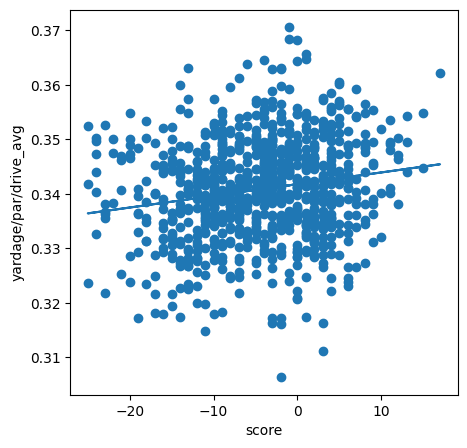

In [79]:
plot('score','yardage/par/drive_avg',training_df)

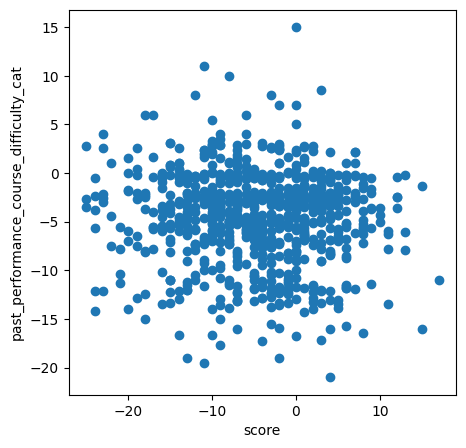

In [81]:
plot('score','past_performance_course_difficulty_cat',training_df)

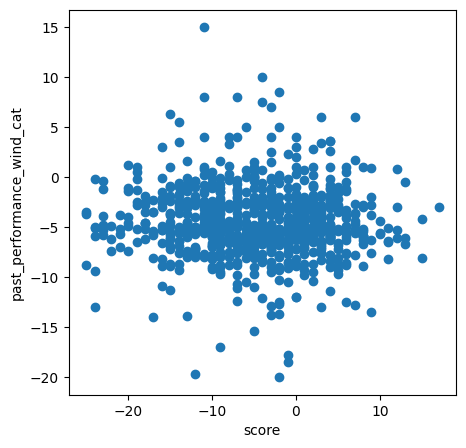

In [82]:
plot('score','past_performance_wind_cat',training_df)

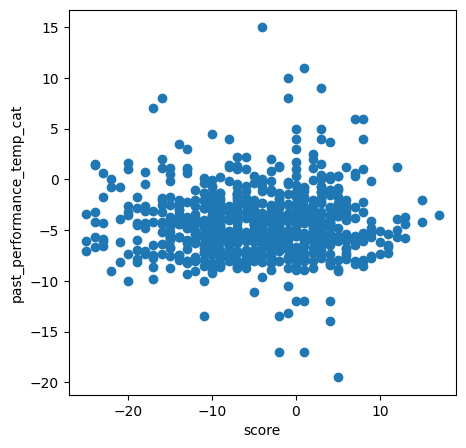

In [83]:
plot('score','past_performance_temp_cat',training_df)

In [ ]:
plot('score','past_performance_course_rainy',training_df)

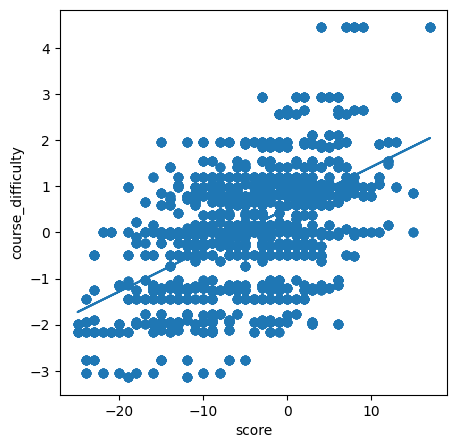

In [495]:
plot('score','course_difficulty',training_df)

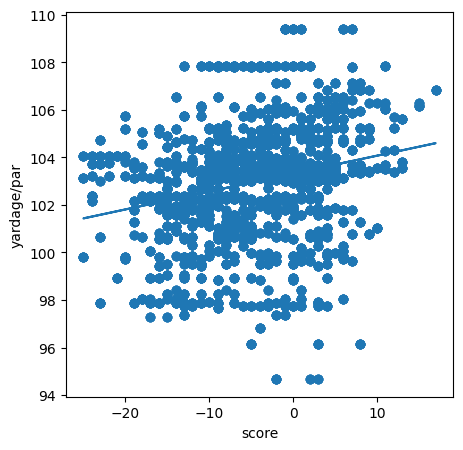

In [496]:
plot('score','yardage/par',training_df)

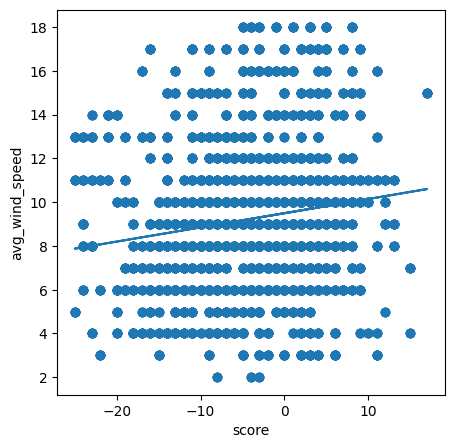

In [497]:
plot('score','avg_wind_speed',training_df)

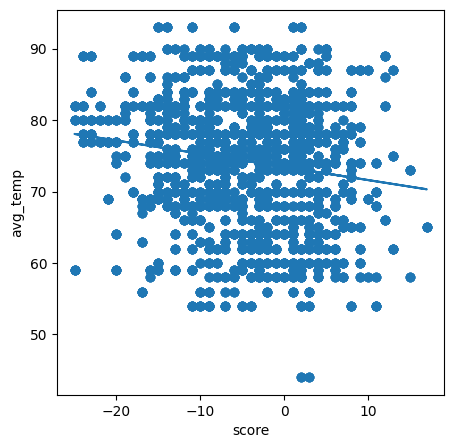

In [498]:
plot('score','avg_temp',training_df)

In [488]:
training_df.corr()['score'].sort_values(ascending=False)

score                       1.000000
course_difficulty           0.544877
yardage/par                 0.234477
avg_wind_speed              0.150807
rainy                       0.092795
cloudy                      0.051828
sunny                       0.024294
drive_avg                   0.019491
strokes_gained              0.008779
scrambling_pct              0.007516
strokes_gained_total        0.004130
strokes_gained_tee_green   -0.002058
scoring_avg                -0.006911
putt_avg                   -0.009500
gir_pct                    -0.015564
drive_acc                  -0.021581
avg_temp                   -0.156004
Name: score, dtype: float64

In [486]:
training_df.describe()

,course_difficulty,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,score,yardage/par,avg_temp,avg_wind_speed,cloudy,sunny,rainy
count,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000,6659.000000
mean,0.107423,302.518141,61.437075,67.899638,1.746697,0.045831,60.868734,70.176487,0.867760,0.913499,-4.573510,102.970463,74.290434,9.201832,0.649347,0.478450,0.031536
std,1.263247,4.606025,4.568950,2.117068,0.020892,0.325936,2.641533,0.511540,0.410571,0.486711,7.662809,2.462776,9.063478,3.298113,0.477210,0.499573,0.174775
min,-3.140000,294.700000,53.010000,62.210000,1.699000,-0.683000,55.720000,69.083000,0.092000,-0.162000,-25.000000,94.666667,44.000000,2.000000,0.000000,0.000000,0.000000
25%,-0.490000,298.200000,58.820000,66.470000,1.734000,-0.119000,59.140000,69.841000,0.493000,0.641000,-10.000000,101.591549,68.000000,7.000000,0.000000,0.000000,0.000000
50%,0.100000,303.100000,60.620000,68.290000,1.745000,0.067000,60.740000,70.116000,0.986000,0.976000,-4.000000,103.305556,75.000000,9.000000,1.000000,0.000000,0.000000
75%,0.990000,307.500000,65.030000,69.380000,1.758000,0.303000,63.050000,70.563000,1.227000,1.232000,1.000000,104.541667,82.000000,11.000000,1.000000,1.000000,0.000000
max,4.450000,310.200000,72.100000,71.880000,1.793000,0.668000,66.490000,71.330000,1.547000,1.869000,17.000000,109.388889,93.000000,18.000000,1.000000,1.000000,1.000000


## Split Data

In [413]:
training_df.columns

Index(['course_difficulty', 'drive_avg', 'drive_acc', 'gir_pct', 'putt_avg',
       'strokes_gained', 'scrambling_pct', 'scoring_avg',
       'strokes_gained_tee_green', 'strokes_gained_total', 'score',
       'yardage/par', 'avg_temp', 'avg_wind_speed', 'cloudy', 'sunny',
       'rainy'],
      dtype='object')

In [414]:
features_df = training_df[FEATURES]
labels_df = training_df[LABELS]

# split data into 90% training and 10% testing
x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=TEST_SIZE)

## Preprocessing

In [416]:
scaler = StandardScaler()

In [417]:
x_train_scaled = pd.concat(
    [pd.DataFrame(scaler.fit_transform(x_train[FEATURES_TO_SCALE]), index=x_train.index, columns=FEATURES_TO_SCALE),
     pd.DataFrame(x_train[FEATURES_TO_NOT_SCALE], index=x_train.index, columns=FEATURES_TO_NOT_SCALE)],
     axis=1)

x_test_scaled = pd.concat(
    [pd.DataFrame(scaler.transform(x_test[FEATURES_TO_SCALE]), index=x_test.index, columns=FEATURES_TO_SCALE),
     pd.DataFrame(x_test[FEATURES_TO_NOT_SCALE], index=x_test.index, columns=FEATURES_TO_NOT_SCALE)],
     axis=1)

In [418]:
#x_train_scaled.head()
x_test_scaled.head()

,course_difficulty,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,yardage/par,avg_temp,avg_wind_speed,cloudy,sunny,rainy
4945,-0.983085,-1.308012,-0.152929,-0.389855,0.154954,-0.507257,1.263637,-0.047710,0.377018,-0.018736,0.684321,-0.032110,-0.059293,1,0,0
1803,-0.911796,0.404313,-0.976464,0.305213,0.395037,-1.584936,1.071001,-0.803478,1.384814,0.108263,-2.265834,-0.472215,1.455376,1,0,0
3668,0.743692,-0.571062,0.180878,-0.408769,-0.085129,-1.474089,0.062494,0.748963,0.508788,-0.553362,0.292614,-0.472215,-0.362226,0,1,0
6648,0.561509,0.360963,-1.848314,-1.449007,-2.101822,1.352508,-0.681611,0.045787,-1.370154,-0.252251,0.167623,-1.132373,2.061243,1,0,0
5899,-0.135538,-1.589787,1.795008,1.373821,-0.805376,-1.547987,-1.255742,-0.135364,1.616631,0.327440,-1.083349,-0.472215,-0.362226,1,0,0


## Training

In [419]:
model = XGBRegressor(random_state=SEED, objective='reg:squarederror')
#n_estimators=100, max_depth=15, 

In [420]:
model.fit(x_train_scaled,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2015,
             reg_alpha=0, reg_lambda=1, ...)

In [421]:
get_score(model, x_train_scaled, y_train)

Cross-Validation Root Mean Squared Error: [6.30791893 6.19752298 6.4679116  6.19886731 6.2119169  6.36289656
 6.4886587  6.36768059]
Average Root Mean Squared Error: 6.32542
Standard deviation: 0.10938


In [504]:
model.feature_importances_

array([0.37768805, 0.00520046, 0.00534843, 0.00551019, 0.02561678,
       0.00608858, 0.00344082, 0.00673258, 0.00418471, 0.00497407,
       0.08706016, 0.09461129, 0.07852309, 0.08715896, 0.09193563,
       0.11592624], dtype=float32)

In [505]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]

In [506]:
for index in sorted_idx:
    print([x_train_scaled.columns[index], model.feature_importances_[index]]) 

['course_difficulty', 0.37768805]
['rainy', 0.115926236]
['avg_temp', 0.09461129]
['sunny', 0.091935635]
['cloudy', 0.087158956]
['yardage/par', 0.08706016]
['avg_wind_speed', 0.07852309]
['putt_avg', 0.025616778]
['scoring_avg', 0.006732576]
['strokes_gained', 0.006088583]
['gir_pct', 0.005510193]
['drive_acc', 0.005348426]
['drive_avg', 0.005200464]
['strokes_gained_total', 0.0049740714]
['strokes_gained_tee_green', 0.004184705]
['scrambling_pct', 0.0034408243]


In [ ]:
# try neural network and SVM and linear/ridge regression

## Predict

In [501]:
preds = np.array(model.predict(x_test_scaled))

In [502]:
print(f'Model Predicted Scores vs Actual Scores for {players.keys()} Previous Tournaments')
for a,b in zip(preds, y_test.values):
    print(f'Predicted Score: {int(a)}, Actual Score: {int(*b,)}')


Model Predicted Scores vs Actual Scores for dict_keys(['xander_schauffele', 'collin_morikawa', 'keegan_bradley', 'sungjae_im', 'rickie_fowler', 'hideki_matsuyama', 'sahith_theegala', 'cameron_davis', 'eric_cole']) Previous Tournaments
Predicted Score: -7, Actual Score: -10
Predicted Score: -1, Actual Score: -13
Predicted Score: 1, Actual Score: 11
Predicted Score: 0, Actual Score: -1
Predicted Score: -10, Actual Score: -8
Predicted Score: 0, Actual Score: -5
Predicted Score: -4, Actual Score: -15
Predicted Score: 4, Actual Score: -2
Predicted Score: -12, Actual Score: -5
Predicted Score: -5, Actual Score: -3
Predicted Score: -1, Actual Score: -4
Predicted Score: 6, Actual Score: 8
Predicted Score: -3, Actual Score: 0
Predicted Score: 8, Actual Score: 11
Predicted Score: -6, Actual Score: -3
Predicted Score: -8, Actual Score: -15
Predicted Score: 3, Actual Score: -2
Predicted Score: 3, Actual Score: 1
Predicted Score: -5, Actual Score: -9
Predicted Score: -11, Actual Score: -11
Predicte

In [424]:
get_results(preds, y_test)

Final RMSE: 7.78463


In [445]:
next_tournament_course_info = ast.literal_eval(next_tournament['venue'])['courses'][0]

In [454]:
next_tournament_course_difficulty = get_next_tournament_course_difficulty(course_difficulty_df, next_tournament_course_info['name'])

In [464]:
pred_df = generate_pred_df(season_stats_training_df, next_tournament_course_info, next_tournament_course_difficulty, NEXT_TOURNAMENT_CONDITION_INFO)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [467]:
pred_df.head()

,first_name,last_name,year,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,course_difficulty,yardage/par,avg_temp,avg_wind_speed,cloudy,sunny,rainy
0,Collin,Morikawa,2023,294.7,69.55,70.85,1.749,-0.109,59.65,69.608,1.547,1.438,0.0,1.0,74,9,0,1,0
1,Sahith,Theegala,2023,304.2,53.01,64.83,1.703,0.485,59.08,70.202,0.304,0.788,0.0,1.0,74,9,0,1,0
2,Cameron,Davis,2023,310.2,55.20,67.27,1.764,-0.205,60.74,70.328,0.860,0.655,0.0,1.0,74,9,0,1,0
3,Hideki,Matsuyama,2023,296.5,60.73,67.07,1.750,-0.119,64.23,70.154,1.020,0.902,0.0,1.0,74,9,0,1,0
4,Sungjae,Im,2023,298.2,63.04,66.39,1.740,0.207,62.98,69.893,0.842,1.049,0.0,1.0,74,9,0,1,0


In [468]:
final_pred_df = pd.concat(
    [pd.DataFrame(scaler.transform(pred_df[FEATURES_TO_SCALE]), index=pred_df.index, columns=FEATURES_TO_SCALE),
     pd.DataFrame(pred_df[FEATURES_TO_NOT_SCALE], index=pred_df.index, columns=FEATURES_TO_NOT_SCALE)],
     axis=1)

In [469]:
final_pred_df.head()

,course_difficulty,drive_avg,drive_acc,gir_pct,putt_avg,strokes_gained,scrambling_pct,scoring_avg,strokes_gained_tee_green,strokes_gained_total,yardage/par,avg_temp,avg_wind_speed,cloudy,sunny,rainy
0,-0.088013,-1.698162,1.784028,1.397463,0.106937,-0.476466,-0.466311,-1.111240,1.662995,1.079194,-41.283575,-0.03211,-0.059293,0,1,0
1,-0.088013,0.360963,-1.848314,-1.449007,-2.101822,1.352508,-0.681611,0.045787,-1.370154,-0.252251,-41.283575,-0.03211,-0.059293,0,1,0
2,-0.088013,1.661463,-1.367370,-0.295288,0.827185,-0.772058,-0.054599,0.291217,-0.013411,-0.524685,-41.283575,-0.03211,-0.059293,0,1,0
3,-0.088013,-1.308012,-0.152929,-0.389855,0.154954,-0.507257,1.263637,-0.047710,0.377018,-0.018736,-41.283575,-0.03211,-0.059293,0,1,0
4,-0.088013,-0.939537,0.354370,-0.711384,-0.325211,0.496523,0.791490,-0.556101,-0.057335,0.282375,-41.283575,-0.03211,-0.059293,0,1,0


In [470]:
final_preds = np.array(model.predict(final_pred_df))

In [475]:
print(f'final predictions for next tournament:\n')
print(pd.DataFrame({'first_name': pred_df['first_name'].values, 'last_name': pred_df['last_name'].values, 'projected_score': final_preds}).sort_values(by='projected_score'))

final predictions for next tournament:

  first_name   last_name  projected_score
6     Keegan     Bradley       -14.930865
4    Sungjae          Im       -14.618444
3     Hideki   Matsuyama       -13.704328
2    Cameron       Davis       -13.175954
5     Rickie      Fowler       -13.081285
8       Eric        Cole       -12.662240
0     Collin    Morikawa       -12.578970
7     Xander  Schauffele       -12.042275
1     Sahith    Theegala       -11.919237


## Temp stuff

In [128]:
training_df['conditions'].values[:5]

array([list(['Clear', 'Clear', 'Light Drizzle And Rain', 'Light Drizzle And Rain']),
       list(['Partly cloudy', 'Sunny', 'Overcast', 'Partly cloudy']),
       list(['Sunny', 'Sunny', 'Sunny', 'Sunny']),
       list(['Sunny', 'Sunny', 'Partly cloudy', 'Sunny']),
       list(['Partly cloudy', 'Sunny', 'Patchy rain possible', 'Partly cloudy'])],
      dtype=object)

In [127]:
from collections import Counter
Counter([item for sublist in training_df['conditions'].values for item in sublist])

Counter({'Clear': 8,
         'Light Drizzle And Rain': 2,
         'Partly cloudy': 190,
         'Sunny': 149,
         'Overcast': 41,
         'Patchy rain possible': 5,
         'Light Rain': 9,
         'Light Rain Shower': 3,
         'Thundery outbreaks possible': 1,
         'Cloudy': 2,
         'Haze': 1,
         'Thunderstorm In Vicinity, Light Rain': 1,
         'Patchy light rain with thunder': 1,
         'Mist': 1,
         'Light Rain, Mist': 1,
         'Shower In Vicinity': 1})

In [318]:
response = requests.get(TOURNAMENT_LEADERBOARD_URL.format(year=2023,tournament_id='231bafc7-b92c-49f8-ab5a-f3c705ae33b8',api_key=API_KEY))

In [319]:
response.json()

{'id': '231bafc7-b92c-49f8-ab5a-f3c705ae33b8',
 'name': 'ZOZO CHAMPIONSHIP',
 'event_type': 'stroke',
 'purse': 8500000.0,
 'currency': 'USD',
 'start_date': '2023-10-19',
 'end_date': '2023-10-22',
 'course_timezone': 'Asia/Tokyo',
 'seasons': [{'id': 'ece9907c-6fe3-4944-8cb9-bb1033270259',
   'year': 2023,
   'tour': {'id': 'b52068af-28e4-4e91-bdbb-037591b0ff84',
    'alias': 'pga',
    'name': 'PGA Tour'}}]}

In [316]:
print(TOURNAMENT_LEADERBOARD_URL)

https://api.sportradar.us/golf/trial/pga/v3/en/{year}/tournaments/{tournament_id}/leaderboard.json?api_key={api_key}


In [292]:
response = requests.get(temp_url.format(season='2022'), headers={"Ocp-Apim-Subscription-Key": temp_api_key})
temp_df2 = pd.DataFrame(response.json())

In [ ]:
temp_df2.head()

In [294]:
print(temp_url)

https://api.sportsdata.io/golf/v2/json/PlayerSeasonStats/{season}


In [106]:
response = requests.get(TOURNAMENTS_SCHEDULE_URL.format(year=CURRENT_YEAR,api_key=API_KEY))

In [109]:
response.json()['tournaments']

[{'id': '40ef66e7-2c3e-4102-9132-2c6d828acdb6',
  'name': 'Fortinet Championship',
  'event_type': 'stroke',
  'purse': 8000000.0,
  'winning_share': 1440000.0,
  'currency': 'USD',
  'points': 500,
  'start_date': '2022-09-15',
  'end_date': '2022-09-18',
  'course_timezone': 'America/Los_Angeles',
  'network': 'Golf Channel',
  'total_rounds': 4,
  'status': 'closed',
  'cutline': -2,
  'projected_cutline': -2,
  'cut_round': 2,
  'defending_champ': {'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',
   'first_name': 'Max',
   'last_name': 'Homa',
   'height': 73,
   'weight': 180,
   'birthday': '1990-11-19',
   'country': 'UNITED STATES',
   'residence': 'Valencia, CA, USA',
   'birth_place': 'Valencia, CA, USA',
   'college': 'California',
   'turned_pro': 2013,
   'handedness': 'R',
   'abbr_name': 'M.Homa'},
  'winner': {'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',
   'first_name': 'Max',
   'last_name': 'Homa',
   'height': 73,
   'weight': 180,
   'birthday': '1990-11-19T00:00:00+

In [92]:
response = requests.get(TOURNAMENT_SUMMARY_URL.format(year=CURRENT_YEAR, tournament_id=TOURNAMENT_ID_TEMP, api_key=API_KEY))


In [98]:
response.json().keys()

dict_keys(['id', 'name', 'event_type', 'purse', 'winning_share', 'currency', 'points', 'start_date', 'end_date', 'course_timezone', 'status', 'seasons', 'coverage', 'venue', 'rounds', 'field'])

In [ ]:
pd.

In [104]:
response.json()['venue']

{'id': 'b2efd1bd-12e5-4dd2-941d-ba9f86f4fd78',
 'name': 'Accordia Golf Narashino Country Club',
 'city': 'Chiba',
 'country': 'JPN',
 'courses': [{'id': 'b5472441-c89d-4afb-a793-7df1cd7710cd',
   'name': 'Accordia Golf Narashino Country Club',
   'yardage': 7079,
   'par': 70,
   'holes': [{'number': 1, 'par': 4, 'yardage': 405},
    {'number': 2, 'par': 4, 'yardage': 363},
    {'number': 3, 'par': 3, 'yardage': 180},
    {'number': 4, 'par': 4, 'yardage': 505},
    {'number': 5, 'par': 3, 'yardage': 205},
    {'number': 6, 'par': 5, 'yardage': 587},
    {'number': 7, 'par': 3, 'yardage': 167},
    {'number': 8, 'par': 4, 'yardage': 395},
    {'number': 9, 'par': 4, 'yardage': 486},
    {'number': 10, 'par': 4, 'yardage': 400},
    {'number': 11, 'par': 4, 'yardage': 486},
    {'number': 12, 'par': 4, 'yardage': 490},
    {'number': 13, 'par': 3, 'yardage': 141},
    {'number': 14, 'par': 5, 'yardage': 608},
    {'number': 15, 'par': 4, 'yardage': 425},
    {'number': 16, 'par': 3, 'ya

In [101]:
response.json()['rounds']

[{'id': '0ecd06da-2407-4351-89cd-efc02a4e3fad',
  'number': 1,
  'status': 'closed',
  'weather': {'temp': 59,
   'condition': 'Light Rain',
   'wind': {'speed': 12, 'direction': 'NNW'}},
  'broadcasts': [{'network': 'Golf Channel',
    'satellite': '218',
    'start_at': '2022-10-13T03:00:00+00:00',
    'end_at': '2022-10-13T07:00:00+00:00'},
   {'internet': 'Peacock',
    'start_at': '2022-10-13T03:00:00+00:00',
    'end_at': '2022-10-13T07:00:00+00:00'}]},
 {'id': 'a65d0c71-dc3c-449f-a8dd-b81a5bdc9a6e',
  'number': 2,
  'status': 'closed',
  'weather': {'temp': 68,
   'condition': 'Partly cloudy',
   'wind': {'speed': 13, 'direction': 'N'}},
  'broadcasts': [{'network': 'Golf Channel',
    'satellite': '218',
    'start_at': '2022-10-14T03:00:00+00:00',
    'end_at': '2022-10-14T07:00:00+00:00'},
   {'internet': 'Peacock',
    'start_at': '2022-10-14T03:00:00+00:00',
    'end_at': '2022-10-14T07:00:00+00:00'}]},
 {'id': 'c2550087-3ac0-424f-9dca-26b7cc95a6eb',
  'number': 3,
  'statu

In [105]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in response.json().items() ])).to_csv(f'{PROJECT_PATH}/temp/zozo_tournament_summary.csv', index=False)

In [95]:
pd.DataFrame(response.json()).head()

ValueError: arrays must all be same length

In [45]:
pd.DataFrame(response.json()['previous_tournaments']).to_csv(f'{PROJECT_PATH}/temp/jt_player_previous_tournaments.csv', index=False)

In [46]:
pd.DataFrame(response.json()['statistics']).to_csv(f'{PROJECT_PATH}/temp/jt_player_statistics.csv', index=False)

In [35]:
temp_df = pd.DataFrame(response.json()['leaderboard'])

In [36]:
temp_df.to_csv(f'{PROJECT_PATH}/zozo_leaderboard.csv', index=False)

In [32]:
player_stats_df = get_df_from_api(url=PLAYER_STATS_URL, data_name='players', new_request=True)

In [41]:
tournament_schedules_df = get_tournament_schedules_df(new_request=True)

In [66]:
tournament_schedules_df.head()

,id,name,event_type,purse,winning_share,currency,points,start_date,end_date,course_timezone,network,total_rounds,status,cutline,projected_cutline,cut_round,defending_champ,winner,venue
0,40ef66e7-2c3e-4102-9132-2c6d828acdb6,Fortinet Championship,stroke,8000000.0,1440000.0,USD,500.0,2022-09-15,2022-09-18,America/Los_Angeles,Golf Channel,4.0,closed,-2.0,-2.0,2.0,"{'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',...","{'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',...","{'id': '117a15a3-be47-4216-9bbe-04a477a5a15c',..."
1,670f3ee8-8d8d-4aff-96cc-dfb555d94526,Presidents Cup,cup,NaN,NaN,USD,NaN,2022-09-22,2022-09-25,America/New_York,"Golf Channel, NBC",5.0,closed,NaN,NaN,NaN,NaN,NaN,"{'id': 'bb66b3fb-7248-47d5-ade5-291c704c040c',..."
2,80f07484-b938-4054-bb8f-1dee801f371d,Sanderson Farms Championship,stroke,7900000.0,1422000.0,USD,500.0,2022-09-29,2022-10-02,America/Chicago,Golf Channel,4.0,closed,-2.0,-2.0,2.0,"{'id': 'f572509d-7c6d-48b9-9c65-a20f6d2d492b',...","{'id': '6cad8490-72de-4df2-9d6a-ee1be88df338',...","{'id': '3d7993d0-7448-4670-b793-f7d7dfe03ed1',..."
3,930073f3-a6ca-4501-97ee-54140730dba0,Shriners Children's Open,stroke,8000000.0,1440000.0,USD,500.0,2022-10-06,2022-10-09,America/Los_Angeles,Golf Channel,4.0,closed,-4.0,-4.0,2.0,"{'id': 'ac1db384-8cb4-4223-bc46-60f4ed963645',...","{'id': 'aca3420a-9ed0-444d-b214-f831561f7c71',...","{'id': '4743d27b-678f-496f-a6b3-b90549955a14',..."
4,3a247fb8-ba65-4c23-915f-f442c36d65fd,ZOZO CHAMPIONSHIP,stroke,11000000.0,1980000.0,USD,500.0,2022-10-13,2022-10-16,Asia/Tokyo,Golf Channel,4.0,closed,NaN,NaN,NaN,"{'id': 'd45bcf4a-5803-4b0b-ab6c-6427a76cecf7',...","{'id': '0b5d3fd6-e3ec-4efd-8743-60db44c87425',...","{'id': 'b2efd1bd-12e5-4dd2-941d-ba9f86f4fd78',..."


In [57]:
next_tournament = tournament_schedules_df[tournament_schedules_df['status']=='scheduled'].iloc[0]

In [58]:
next_tournament.id

'57742754-1bc9-4c78-8b1c-cd1cea3c6db6'

In [59]:
next_tournament

id                                57742754-1bc9-4c78-8b1c-cd1cea3c6db6
name                                                 TOUR Championship
event_type                                                      stroke
purse                                                              NaN
winning_share                                                      NaN
currency                                                           USD
points                                                             0.0
start_date                                                  2023-08-24
end_date                                                    2023-08-27
course_timezone                                       America/New_York
network                                              Golf Channel, CBS
total_rounds                                                       NaN
status                                                       scheduled
cutline                                                            NaN
projec